# VGG-16

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0],
 True)
import keras as K
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
# from tensorflow.keras import datasets, layers, models

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.applications.vgg16 import VGG16

2024-11-26 22:56:44.355750: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-26 22:56:44.367325: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732679804.379947   90927 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732679804.383481   90927 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 22:56:44.396150: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Preparation for trainning - Train Split

In [3]:
path = os.path.realpath('data/Dataset of Breast mammography images with Masses')
list_path = path.split('/')
list_path.remove('notebooks')
list_path.remove('breast-cancer-project')
path = os.path.join('/'.join(list_path), 'Image After Data Augmentation, Image Size 224x224/')

In [4]:
batch_size_n = 8

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(224, 224),
    batch_size=batch_size_n,
)

Found 7632 files belonging to 8 classes.
Using 6106 files for training.


I0000 00:00:1732679807.661160   90927 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1756 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [6]:
classes_ = train_ds.class_names
len(classes_)

8

In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(224, 224),
    batch_size=batch_size_n,
)

Found 7632 files belonging to 8 classes.
Using 1526 files for validation.


In [8]:
def normalize(image, label):
  return tf.cast(image/255., tf.float32), label

train_ds = train_ds.map(normalize)
val_ds = val_ds.map(normalize)

train_ds, val_ds

(<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

# Preparation for trainning - Test Split

In [9]:
path = os.path.realpath('data/Dataset of Breast mammography images with Masses')
list_path = path.split('/')
list_path.remove('notebooks')
list_path.remove('breast-cancer-project')
path = os.path.join('/'.join(list_path), 'Image Before Data Augmentation, Image Size 224x224/')

In [10]:
train_ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(224, 224),
    batch_size=batch_size_n,
)

Found 212 files belonging to 8 classes.
Using 170 files for training.


In [11]:
val_ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(224, 224),
    batch_size=batch_size_n,
)

Found 212 files belonging to 8 classes.
Using 42 files for validation.


In [12]:
def normalize(image, label):
  return tf.cast(image/255., tf.float32), label

train_ds_test = train_ds_test.map(normalize)
val_ds_test = val_ds_test.map(normalize)

train_ds_test, val_ds_test

(<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

# Training

In [13]:
from tensorflow.keras import mixed_precision


mixed_precision.set_global_policy('mixed_float16')

In [14]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

I0000 00:00:1732679808.694523   90927 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1756 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [15]:
with session.as_default():
    base_model = VGG16(weights=None, include_top=False, input_shape=(224, 224, 3), classes=8)
    x = base_model.output
    x = Flatten()(x)
    last_layer = Dense(8, activation='softmax')(x)

In [16]:
model = tf.keras.Model(inputs=base_model.input, outputs=last_layer)

In [17]:
model.compile(optimizer='adam',
              loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

In [18]:
epochs = 50
history = model.fit(train_ds,
                    validation_data=val_ds,
                    batch_size=batch_size_n,
                    epochs=epochs)

Epoch 1/50


I0000 00:00:1732679811.737873   91029 service.cc:148] XLA service 0x7f3e5c01c890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732679811.737943   91029 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-11-26 22:56:51.816257: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732679812.201753   91029 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-26 22:57:00.185540: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng19{k2=2} for conv (f16[64,3,3,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[8,224,224,64]{3,2,1,0}, f16[8,224,224,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_re

764/764 ━━━━━━━━━━━━━━━━━━━━ 160s 164ms/step - accuracy: 0.2898 - loss: 1.8847 - val_accuracy: 0.3028 - val_loss: 1.7605
Epoch 2/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 51s 67ms/step - accuracy: 0.2939 - loss: 1.7610 - val_accuracy: 0.3028 - val_loss: 1.7593
Epoch 3/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 53s 70ms/step - accuracy: 0.2935 - loss: 1.7576 - val_accuracy: 0.3028 - val_loss: 1.7643
Epoch 4/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 52s 68ms/step - accuracy: 0.2950 - loss: 1.7613 - val_accuracy: 0.3028 - val_loss: 1.7633
Epoch 5/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 53s 69ms/step - accuracy: 0.2966 - loss: 1.7578 - val_accuracy: 0.3028 - val_loss: 1.7664
Epoch 6/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 54s 70ms/step - accuracy: 0.2999 - loss: 1.7562 - val_accuracy: 0.3028 - val_loss: 1.7634
Epoch 7/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 53s 69ms/step - accuracy: 0.2904 - loss: 1.7569 - val_accuracy: 0.3028 - val_loss: 1.7646
Epoch 8/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 53s 69ms/step - accuracy: 0.3016 - loss: 1.7558 - val_accur

# Evaluating

In [19]:
history.history

{'accuracy': [0.2931542694568634,
  0.29282674193382263,
  0.29380935430526733,
  0.29561087489128113,
  0.2967572808265686,
  0.29528331756591797,
  0.29102522134780884,
  0.2987225651741028,
  0.29823124408721924,
  0.2947919964790344,
  0.29806748032569885,
  0.2957746386528015,
  0.2957746386528015,
  0.2969210743904114,
  0.2951195538043976,
  0.29626595973968506,
  0.2965935170650482,
  0.2977399230003357,
  0.2957746386528015,
  0.29528331756591797,
  0.29544711112976074,
  0.29708483815193176,
  0.29642975330352783,
  0.29823124408721924,
  0.29544711112976074,
  0.2951195538043976,
  0.29561087489128113,
  0.29724860191345215,
  0.2983950078487396,
  0.2967572808265686,
  0.29626595973968506,
  0.2993776500225067,
  0.29561087489128113,
  0.2983950078487396,
  0.2987225651741028,
  0.2974123954772949,
  0.29561087489128113,
  0.2965935170650482,
  0.2965935170650482,
  0.29724860191345215,
  0.29921388626098633,
  0.2961021959781647,
  0.2975761592388153,
  0.3001965284347534,

In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │       200,712 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,746,206 (170.69 MB)

 Trainable params: 14,915,400 (56.90 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,830,806 (113.80 MB)

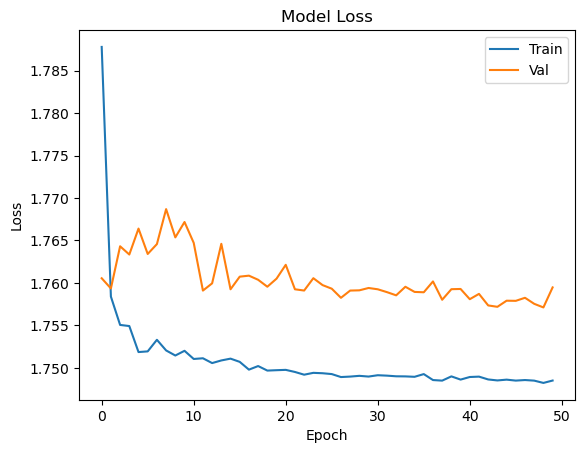

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

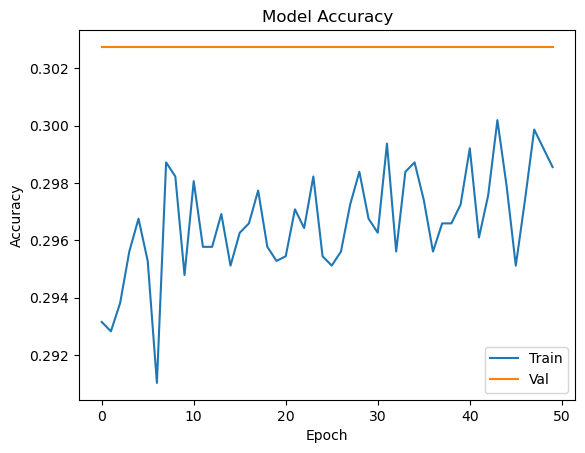

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [23]:
test_loss, test_acc = model.evaluate(val_ds, verbose=2)

191/191 - 4s - 19ms/step - accuracy: 0.3028 - loss: 1.7595


In [24]:
print(test_acc)

0.302752286195755


In [25]:
predictions = model.predict(train_ds_test)
val_pred = np.argmax(predictions, axis=1)

2024-11-26 23:43:31.897036: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step


In [26]:
y_true = []
y_pred = []
for images, labels in val_ds_test:
  # Make predictions on the batch
  batch_pred = model.predict(images)
  y_pred.extend(list(batch_pred.argmax(axis=1)))  # Predicted labels
  y_true.extend(list(labels.numpy()))  # True labels from the batch

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


2024-11-26 23:43:35.728840: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


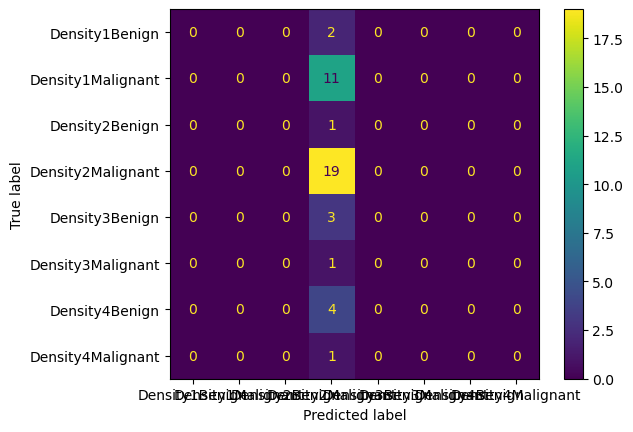

In [27]:
disp = ConfusionMatrixDisplay(cm, display_labels=classes_,)
disp.plot()

In [28]:
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00         1
           3       0.45      1.00      0.62        19
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         1

    accuracy                           0.45        42
   macro avg       0.06      0.12      0.08        42
weighted avg       0.20      0.45      0.28        42



/home/viviane/apps/anaconda3/envs/pro1-cnn/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/viviane/apps/anaconda3/envs/pro1-cnn/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/viviane/apps/anaconda3/envs/pro1-cnn/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

# Save

In [29]:
# model.save('models/breast_cancer_classification-vgg16.h5')